In [ ]:
# Ideas:
# search locales near team members
# counts of observers and how prolific their observations were
# 

In [1]:
# import dependencies
import os
import requests
import json
import pandas as pd
import plotly.express as px
from config import api_key
from config import mapbox_token

%load_ext lab_black

px.set_mapbox_access_token(mapbox_token)

In [8]:
# Obtain list of Texas cities and codes

regionType = "subnational2"
parentRegionCode = "US-TX"

url = (
    "https://api.ebird.org/v2/ref/region/list/"
    + regionType
    + "/"
    + parentRegionCode
    + ".json"
)

r = requests.get(url, params={"key": api_key})

In [9]:
r.url

'https://api.ebird.org/v2/ref/region/list/subnational2/US-TX.json?key=d56mdhi9b35r'

In [56]:
df = pd.DataFrame(r.json())
df.loc[df["name"] == "Austin"]

,code,name
7,US-TX-015,Austin


In [73]:
cities = df["code"].to_list()  # save cities to a list to be able to iterate over later

In [81]:
# Recent notable observations. Notable observations can be for locally or nationally rare species or are otherwise unusual, e.g. over-wintering birds in a 
# species which is normally only a summer visitor. (eBird API documentation)

regionCode = "US-TX"
url_notables = (
    "https://api.ebird.org/v2/data/obs/"
    + regionCode
    + "/recent/notable?back=30"  # max number of days back for observations = 30
)

r_notables = requests.get(url_notables, params={"key": api_key})

In [82]:
r_notables.status_code

200

In [84]:
r_notables.url

'https://api.ebird.org/v2/data/obs/US-TX/recent/notable?back=30&key=d56mdhi9b35r'

In [130]:
df_notables = pd.DataFrame(r_notables.json())
df_notables

,speciesCode,comName,sciName,locId,locName,obsDt,howMany,lat,lng,obsValid,obsReviewed,locationPrivate,subId
0,renpha,Red-necked Phalarope,Phalaropus lobatus,L6225250,Brazos Co.--Sims Lane/Sims Lane Cutoff,2020-09-23 19:40,1,30.674903,-96.517167,False,False,False,S73981093
1,renpha,Red-necked Phalarope,Phalaropus lobatus,L6225250,Brazos Co.--Sims Lane/Sims Lane Cutoff,2020-09-23 19:40,1,30.674903,-96.517167,False,False,False,S73981091
2,renpha,Red-necked Phalarope,Phalaropus lobatus,L6225250,Brazos Co.--Sims Lane/Sims Lane Cutoff,2020-09-23 19:40,1,30.674903,-96.517167,False,False,False,S73982501
3,renpha,Red-necked Phalarope,Phalaropus lobatus,L6225250,Brazos Co.--Sims Lane/Sims Lane Cutoff,2020-09-23 19:40,1,30.674903,-96.517167,False,False,False,S73981092
4,mutswa,Mute Swan,Cygnus olor,L12354201,"21518 Falvel Lake Dr, Spring US-TX 30.07537, -...",2020-09-23 19:10,2,30.075375,-95.479560,False,False,True,S73980253
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2428,leagre,Least Grebe,Tachybaptus dominicus,L122362,Village Creek Drying Beds (PPW-W 083),2020-08-25 06:45,2,32.784279,-97.126618,True,True,False,S72808918
2429,wilsni1,Wilson's Snipe,Gallinago delicata,L122362,Village Creek Drying Beds (PPW-W 083),2020-08-25 06:45,1,32.784279,-97.126618,True,True,False,S72808918
2430,annhum,Anna's Hummingbird,Calypte anna,L128955,"Memorial Park (FWTX 9), El Paso",2020-08-25 06:37,1,31.790543,-106.454960,True,True,False,S72803740
2431,robgro,Rose-breasted Grosbeak,Pheucticus ludovicianus,L12148408,"4903 Love Rd, El Paso US-TX 31.83754, -106.58196",2020-08-25 06:36,1,31.837541,-106.581959,True,True,True,S72803933


In [123]:
df_notables.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2433 entries, 0 to 2432
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   speciesCode      2433 non-null   object 
 1   comName          2433 non-null   object 
 2   sciName          2433 non-null   object 
 3   locId            2433 non-null   object 
 4   locName          2433 non-null   object 
 5   obsDt            2433 non-null   object 
 6   howMany          2433 non-null   int64  
 7   lat              2433 non-null   float64
 8   lng              2433 non-null   float64
 9   obsValid         2433 non-null   bool   
 10  obsReviewed      2433 non-null   bool   
 11  locationPrivate  2433 non-null   bool   
 12  subId            2433 non-null   object 
dtypes: bool(3), float64(2), int64(1), object(7)
memory usage: 197.3+ KB


In [115]:
# "https://api.ebird.org/v2/data/obs/geo/recent/notable?lat={{lat}}&lng={{lng}}"  # Get list of notable obs (up to 30 days ago) of birds seen at locations within a radius of up to 50 kilometers, from a given set of coordinates.
# Get nearby hotspots, then get data for specific hotspot(s)
url_notables_hotspots = (
    "https://api.ebird.org/v2/data/obs/"
    + regionCode
    + "/recent/notable"  # max number of days back for observations = 30
)

r_notables_hotspots = requests.get(
    url_notables_hotspots, params={"key": api_key, "back": 30, "hotspot": "True"}
)

In [116]:
r_notables_hotspots.status_code

200

In [117]:
df_notables_hotspots = pd.DataFrame(r_notables_hotspots.json())
df_notables_hotspots

,speciesCode,comName,sciName,locId,locName,obsDt,howMany,lat,lng,obsValid,obsReviewed,locationPrivate,subId
0,renpha,Red-necked Phalarope,Phalaropus lobatus,L6225250,Brazos Co.--Sims Lane/Sims Lane Cutoff,2020-09-23 19:40,1,30.674903,-96.517167,False,False,False,S73981091
1,renpha,Red-necked Phalarope,Phalaropus lobatus,L6225250,Brazos Co.--Sims Lane/Sims Lane Cutoff,2020-09-23 19:40,1,30.674903,-96.517167,False,False,False,S73982501
2,renpha,Red-necked Phalarope,Phalaropus lobatus,L6225250,Brazos Co.--Sims Lane/Sims Lane Cutoff,2020-09-23 19:40,1,30.674903,-96.517167,False,False,False,S73981093
3,renpha,Red-necked Phalarope,Phalaropus lobatus,L6225250,Brazos Co.--Sims Lane/Sims Lane Cutoff,2020-09-23 19:40,1,30.674903,-96.517167,False,False,False,S73981092
4,renpha,Red-necked Phalarope,Phalaropus lobatus,L6225250,Brazos Co.--Sims Lane/Sims Lane Cutoff,2020-09-23 19:10,1,30.674903,-96.517167,False,False,False,S73982306
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1610,aldfly,Alder Flycatcher,Empidonax alnorum,L122362,Village Creek Drying Beds (PPW-W 083),2020-08-25 06:45,1,32.784279,-97.126618,True,True,False,S72808918
1611,leagre,Least Grebe,Tachybaptus dominicus,L122362,Village Creek Drying Beds (PPW-W 083),2020-08-25 06:45,2,32.784279,-97.126618,True,True,False,S72808918
1612,wilsni1,Wilson's Snipe,Gallinago delicata,L122362,Village Creek Drying Beds (PPW-W 083),2020-08-25 06:45,1,32.784279,-97.126618,True,True,False,S72808918
1613,annhum,Anna's Hummingbird,Calypte anna,L128955,"Memorial Park (FWTX 9), El Paso",2020-08-25 06:37,1,31.790543,-106.454960,True,True,False,S72803740


In [121]:
df_notables_hotspots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1615 entries, 0 to 1614
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   speciesCode      1615 non-null   object 
 1   comName          1615 non-null   object 
 2   sciName          1615 non-null   object 
 3   locId            1615 non-null   object 
 4   locName          1615 non-null   object 
 5   obsDt            1615 non-null   object 
 6   howMany          1615 non-null   int64  
 7   lat              1615 non-null   float64
 8   lng              1615 non-null   float64
 9   obsValid         1615 non-null   bool   
 10  obsReviewed      1615 non-null   bool   
 11  locationPrivate  1615 non-null   bool   
 12  subId            1615 non-null   object 
dtypes: bool(3), float64(2), int64(1), object(7)
memory usage: 131.0+ KB


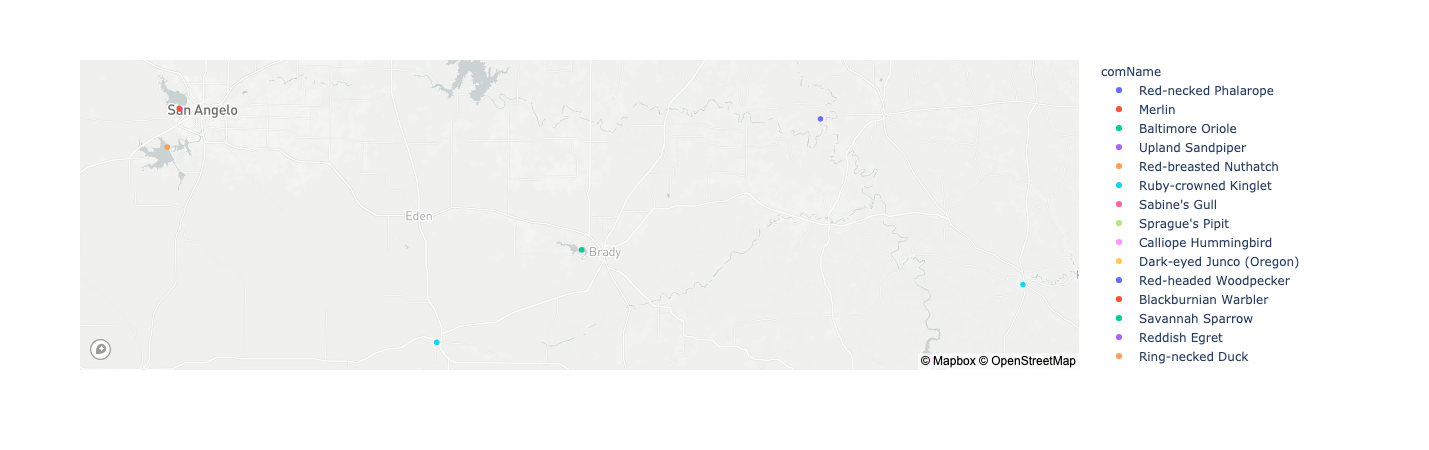

In [132]:
# Map observations with Plotly

fig_hotspots = px.scatter_mapbox(
    df_notables_hotspots,
    lat="lat",
    lon="lng",
    color="comName",
    hover_data=["howMany", "obsDt"],
)
fig_hotspots.show()

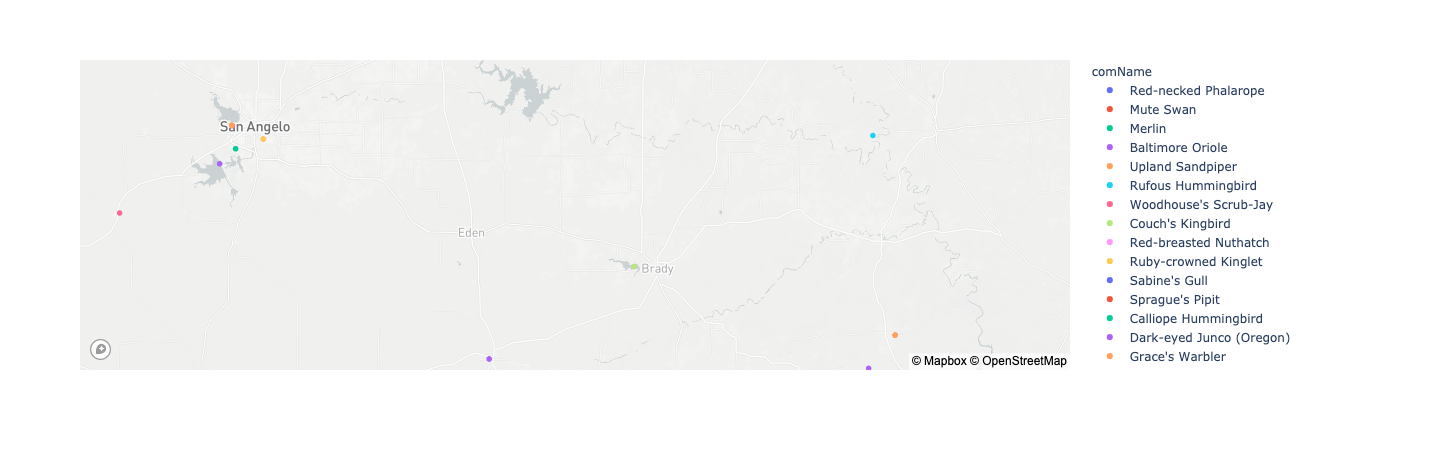

In [131]:
# Maps with plotly

fig_notables = px.scatter_mapbox(
    df_notables, lat="lat", lon="lng", color="comName", hover_data=["howMany", "obsDt"],
)
fig_notables.show()

In [143]:
name_count = df_notables["comName"].value_counts()

In [144]:
names = df_notables["comName"].unique()

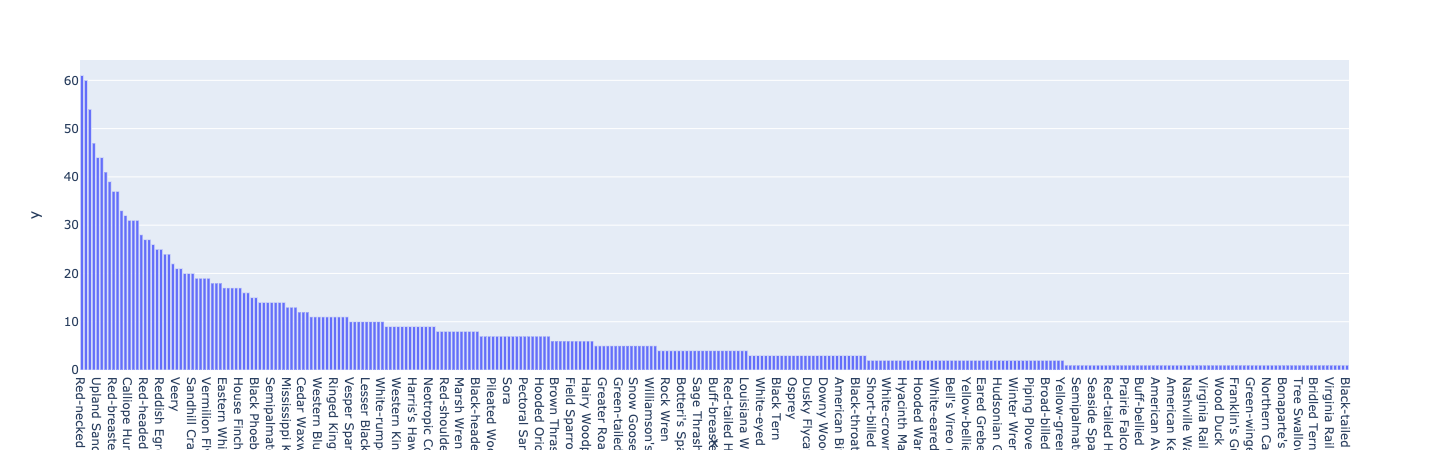

In [145]:
px.bar(
    x=names, y=name_count
)  # bar chart of top 10 or 50. do the same for least observed?

## What makes these observations notable??